In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, help = "path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",help = "path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,default="mask_detector.model",help="path to output face mask detector model")


_StoreAction(option_strings=['-m', '--model'], dest='model', nargs=None, const=None, default='mask_detector.model', type=<class 'str'>, choices=None, help='path to output face mask detector model', metavar=None)

In [4]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("datasets"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
labels[500:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False

C:\Users\Raaj\anaconda\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
33/33 [==============================] - 322s 10s/step - loss: 0.6793 - acc: 0.6325 - val_loss: 0.3051 - val_acc: 0.9044
Epoch 2/20
33/33 [==============================] - 319s 10s/step - loss: 0.4126 - acc: 0.8167 - val_loss: 0.2090 - val_acc: 0.9375
Epoch 3/20
33/33 [==============================] - 288s 9s/step - loss: 0.3015 - acc: 0.8718 - val_loss: 0.1464 - val_acc: 0.9596
Epoch 4/20
33/33 [==============================] - 386s 12s/step - loss: 0.2484 - acc: 0.8946 - val_loss: 0.1168 - val_acc: 0.9706
Epoch 5/20
33/33 [==============================] - 275s 8s/step - loss: 0.2184 - acc: 0.9079 - val_loss: 0.1448 - val_acc: 0.9375
Epoch 6/20
33/33 [==============================] - 283s 9s/step - loss: 0.2134 - acc: 0.9098 - val_loss: 0.1059 - val_acc: 0.9632
Epoch 7/20
33/33 [==============================] - 269s 8s/step - 

Epoch 16/20
33/33 [==============================] - 254s 8s/step - loss: 0.1210 - acc: 0.9516 - val_loss: 0.0674 - val_acc: 0.9743
Epoch 17/20
33/33 [==============================] - 255s 8s/step - loss: 0.1060 - acc: 0.9583 - val_loss: 0.0671 - val_acc: 0.9779
Epoch 18/20
33/33 [==============================] - 255s 8s/step - loss: 0.1128 - acc: 0.9581 - val_loss: 0.0738 - val_acc: 0.9743
Epoch 19/20
33/33 [==============================] - 254s 8s/step - loss: 0.0916 - acc: 0.9649 - val_loss: 0.0687 - val_acc: 0.9743
Epoch 20/20
33/33 [==============================] - 255s 8s/step - loss: 0.1076 - acc: 0.9574 - val_loss: 0.0697 - val_acc: 0.9779


In [10]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

print("[INFO] saving mask detector model...")
model.save("mask_model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.97      0.99      0.98       146
without_mask       0.98      0.97      0.98       126

    accuracy                           0.98       272
   macro avg       0.98      0.98      0.98       272
weighted avg       0.98      0.98      0.98       272

[INFO] saving mask detector model...


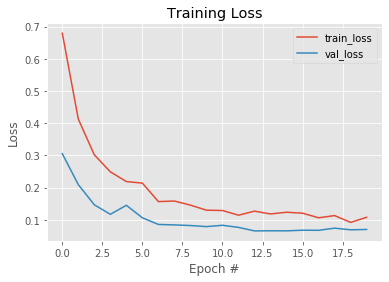

In [11]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")

plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("plot")